## SPATIAL ANALYSIS

In [2]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import zipfile
from zipfile import ZipFile
from sklearn.neighbors import NearestNeighbors
from haversine import haversine, Unit

In [3]:
from astropy.stats import RipleysKEstimator

In [4]:
# For G-function 
import scipy.spatial
#import libpysal as ps
import numpy as np
from pointpats import PointPattern, PoissonPointProcess, as_window, G, F, J, K, L, Genv, Fenv, Jenv, Kenv, Lenv, Window
%matplotlib inline
import matplotlib.pyplot as plt

## Download the Shape file of US Counties


folder_root = '/Users/Anna/Documents/GitHub/Gun_Violence_E19/maps/tl_2017_us_county'

os.chdir(folder_root) # change directions
zip_file = zipfile.ZipFile(os.path.join(folder_root,'tl_2017_us_county.shp.zip')) # open the zip file
zip_file.extractall()
zip_file.close()
county_data = gpd.read_file('tl_2017_us_county.shp') # read the un-zipped shape-file
os.remove(os.path.join(folder_root, 'tl_2017_us_county.shp')) # delete the un-zipped file again, as it is too big to for GitHub sharing


county_data['Statecode'] = pd.to_numeric(county_data['STATEFP'])
county_data = county_data[['Statecode','NAME', 'NAMELSAD','geometry']]

state_names = pd.read_csv('state-geocodes-v2016.csv', sep = ';')
state_names = state_names[['State (FIPS)','Name']]
state_names

geo_county = pd.merge(county_data,state_names,left_on=['Statecode'], right_on = ['State (FIPS)'], how = 'left')

geo_county = geo_county[geo_county['Name']!='Alaska']
geo_county = geo_county[geo_county['Name']!='Hawaii']
geo_county = geo_county[geo_county['Name']!='Districts of Columbia']
geo_county = geo_county.dropna()
geo_county['Name'].unique()

fig, ax = plt.subplots(figsize = (20,20))
geo_county.plot(ax = ax)

plt.xlim(right = -65)
plt.xlim(left = -127)
plt.ylim(bottom = 22.5)


extreme = geo_county.bounds
min_x = extreme['minx'].min()
max_x = extreme['maxx'].max()
min_y = extreme['miny'].min()
max_y = extreme['maxy'].max()

horisontal_grid = np.arange(min_x,max_x,500)
vertical_grid = np.arange(min_y,max_y,500)

x = []
y = [] 

for h in horisontal_grid: 
    for v in vertical_grid: 
        x.append(h)
        y.append(v)

## Spatial Analysis

In [5]:
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Data')
df = pd.read_csv('Data_incidents.csv.zip')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [70]:
df['Mass Shooting'].unique()

array([False, nan, True], dtype=object)

In [6]:
## SPLIT THE DATA INTO THE SUB-GROUPS THAT WE ARE INTERESTED IN

#MASS SHOOTINGS
mass_shootings = df[df['Mass Shooting']== True].reset_index()

#NON SHOOTINGS
non_shootings = df[df['Non-Shooting Incident']== True]

#DEAD SHOOTING EXC. MASS SHOOTINGS
dead_shootings = df[df['Shot - Dead']==True]

dead_shooting = dead_shootings[dead_shootings['Mass Shooting']==False]
dead_shooting = dead_shootings[dead_shootings['Accidental Shooting']==False]

#ALL GUN VIOLENCE
all_gv = df[df['Mass Shooting'] == False]

print(len(mass_shootings),len(non_shootings),len(dead_shooting), len(all_gv))

1352 42134 47928 225150


In [8]:
mass_shootings['state'].unique()
len(mass_shootings)

1352

In [7]:
X_ms = np.array(mass_shootings[['latitude','longitude']]) # extract the long-lat columns for KKN analysis
X_ns = np.array(non_shootings[['latitude','longitude']])
X_ds = np.array(dead_shootings[['latitude','longitude']])
X_gv = np.array(all_gv[['latitude','longitude']])

In [21]:
Mass = mass_shootings[['latitude','longitude']]

## NON-SHOOTING NEIGHBOUR

In [10]:
X_ms

array([[ 36.8508, -76.2859],
       [ 40.6775, -73.7629],
       [ 32.3986, -91.1579],
       ...,
       [ 33.0758, -96.7106],
       [ 39.9321, -75.1027],
       [ 40.2164, -74.0187]])

In [11]:
distances_ns = []
for cor in range(len(X_ms)):
    frame = np.vstack((X_ms[cor],X_ns)) # stack eack ms incident with the comparable incidents
    frame = np.radians(frame) # Convert into radians
    kkn = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='haversine').fit(frame)
    distance, indices = kkn.kneighbors([frame[0]]) # only return distance, indicies for the first row (the mass shooting)
    dist = distance[0][1] * 6371 # convert into km
    ns_cor = frame[indices[0][1]] #coordinates for the nearest neighbor (not saved outside loop)

    distances_ns.append(dist)


## DEAD-SHOOTING NEIGHBOUR

In [12]:
distances_ds = []
for cor in range(len(X_ms)):
    frame = np.vstack((X_ms[cor],X_ds))
    frame = np.radians(frame)
    kkn = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='haversine').fit(frame)
    distance, indices = kkn.kneighbors([frame[0]])
    dist = distance[0][1] * 6371
    ns_cor = frame[indices[0][1]]

    distances_ds.append(dist)

## MASS-SHOOTING NEIGHBOUR

In [13]:
X_ms = np.radians(X_ms)
kkn = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='haversine').fit(X_ms)
distance, indices = kkn.kneighbors()

In [14]:
distances_ms = []
for i in range(len(distance)):
    dist = distance[i][1] * 6371
    distances_ms.append(dist)

In [15]:
nn_ms = pd.DataFrame(distances_ms, columns = ['ms_distance']);
nn_ns = pd.DataFrame(distances_ns, columns = ['ns_distance']);
nn_ds = pd.DataFrame(distances_ds, columns = ['ds_distance']);

In [16]:
print(len(nn_ms), len(nn_ns), len(nn_ds))

1352 1352 1352


In [17]:
# The columns to dataframe
mass_shootings['MS_Dist'] = nn_ms
mass_shootings['NS_Dist'] = nn_ns
mass_shootings['DS_Dist'] = nn_ds

In [18]:
mass_shootings

,index,Unnamed: 0,incident_id,state,city_or_county,n_killed,n_injured,incident_characteristics,latitude,location_description,...,Terrorism Involvement,Officer Involved Shooting - Accidental discharge - no injury required,Mistaken ID,Officer Involved Shooting - subject/suspect/perpetrator suicide by cop,Ghost gun,Political Violence,NAV,MS_Dist,NS_Dist,DS_Dist
0,71,71,92194,Virginia,Norfolk,2,2,"Shot - Wounded/Injured||Shot - Dead (murder, a...",36.8508,NaN,...,False,False,False,False,False,False,False,2.595616,0.447451,0.000000
1,321,321,92704,New York,Queens,1,3,"Shot - Wounded/Injured||Shot - Dead (murder, a...",40.6775,NaN,...,False,False,False,False,False,False,False,2.630121,0.956968,0.000000
2,1481,1481,95500,Louisiana,Tallulah,0,6,Shot - Wounded/Injured||Mass Shooting (4+ vict...,32.3986,103 Klub,...,False,False,False,False,False,False,False,30.537472,26.329290,2.673553
3,1508,1508,95579,Illinois,Elgin,0,5,Shot - Wounded/Injured||Mass Shooting (4+ vict...,42.0401,NaN,...,False,False,False,False,False,False,False,38.002292,0.826531,0.640190
4,1567,1567,95550,Alabama,Huntsville,0,5,Shot - Wounded/Injured||Mass Shooting (4+ vict...,34.7371,NaN,...,False,False,False,False,False,False,False,11.969211,2.151040,0.191025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,225745,225745,1074886,California,San Francisco,1,5,"Shot - Wounded/Injured||Shot - Dead (murder, a...",37.7163,Amazon Barbershop,...,False,False,False,False,False,False,False,4.530501,0.852293,0.000000
1348,226075,226075,1077180,Utah,Salt Lake City (West Valley City),0,4,Shot - Wounded/Injured||Drive-by (car to stree...,40.7021,Walmart,...,False,False,False,False,False,False,False,20.641806,1.280196,0.622692
1349,226575,226575,1080234,Texas,Plano,1,3,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.0758,Cross Creek Apartments,...,False,False,False,False,False,False,False,4.216156,3.052364,0.000000
1350,226620,226620,1080442,New Jersey,Camden,0,4,Shot - Wounded/Injured||Institution/Group/Busi...,39.9321,NaN,...,False,False,False,False,False,False,False,5.916698,0.370844,0.000000


In [19]:
#extract relevant columns
ms_nn = mass_shootings[['state','NS_Dist','DS_Dist','MS_Dist']]

In [20]:
ms_nn_desc_state = ms_nn.groupby(['state']).describe().reset_index() 


In [21]:
sorted_desc1 = ms_nn_desc_state.sort_values(('NS_Dist', 'count'), ascending=False).round(2)

#make range columns
sorted_desc1['NS_Range'] = sorted_desc1[('NS_Dist',   'min')].map(str) +'-'+ sorted_desc1[('NS_Dist',   'max')].map(str)
sorted_desc1['DS_Range'] = sorted_desc1[('DS_Dist',   'min')].map(str) +'-'+ sorted_desc1[('DS_Dist',   'max')].map(str)
sorted_desc1['MS_Range'] = sorted_desc1[('MS_Dist',   'min')].map(str) +'-'+ sorted_desc1[('MS_Dist',   'max')].map(str)

In [22]:
sorted_desc1.head(2)

state NS_Dist                                            DS_Dist  ...  \
                count  mean   std  min   25%   50%   75%     max   count  ...   
3  California   155.0  2.02  8.86  0.0  0.40  0.90  1.62  109.99   155.0  ...   
9    Illinois   133.0  0.86  0.87  0.0  0.34  0.64  1.15    7.58   133.0  ...   

  MS_Dist                                          NS_Range  DS_Range  \
     mean    std   min   25%  50%   75%     max                         
3   13.46  32.06  0.47  1.75  4.1  9.58  299.32  0.0-109.99  0.0-4.53   
9    6.96  16.65  0.22  0.74  1.3  3.52  112.31    0.0-7.58  0.0-6.78   

      MS_Range  
                
3  0.47-299.32  
9  0.22-112.31  

[2 rows x 28 columns]

In [23]:
#sorted_desc.iloc[:, [0,1,2,3,5,9,11,13,17,19,21,25]]
#sorted_desc1.iloc[:, [0,1,2,25,10,26,18,27]].head(10)
print(sorted_desc1.iloc[:, [0,1,2,25,10,26,18,27]].to_latex(index=False))

\begin{tabular}{lrrlrlrl}
\toprule
          state & \multicolumn{2}{l}{NS\_Dist} &     NS\_Range & DS\_Dist &   DS\_Range & MS\_Dist &       MS\_Range \\
                &   count & \multicolumn{2}{l}{mean} & \multicolumn{2}{l}{mean} & \multicolumn{2}{l}{mean} \\
\midrule
     California &   155.0 &   2.02 &   0.0-109.99 &    0.23 &   0.0-4.53 &   13.46 &    0.47-299.32 \\
       Illinois &   133.0 &   0.86 &     0.0-7.58 &    0.16 &   0.0-6.78 &    6.96 &    0.22-112.31 \\
        Florida &   102.0 &   1.45 &     0.0-28.3 &    0.49 &  0.0-20.04 &   16.12 &     0.28-129.1 \\
          Texas &    84.0 &   2.57 &    0.0-17.33 &    0.20 &   0.0-2.46 &   33.24 &    1.84-258.57 \\
       New York &    64.0 &   0.53 &     0.0-4.42 &    0.21 &   0.0-1.97 &    7.39 &    0.15-117.63 \\
        Georgia &    63.0 &   3.34 &    0.0-28.63 &    0.77 &  0.0-16.88 &   21.53 &    0.48-107.45 \\
      Louisiana &    54.0 &   1.04 &    0.0-26.33 &    0.15 &   0.0-2.67 &   11.57 &    0.75-116.26 \\
     

## G-function

### Area definition

In [215]:
northeast = ['Illinois','Wisconsin','Michigan','Indiana']
ms_northeast= mass_shootings.loc[mass_shootings['state'].isin(northeast)].reset_index()
ms_northeast=ms_northeast.drop(columns = 'index')

middleatlantic = ['Connecticut','Massachusetts','Delaware','Maryland','New York','Pennsylvania','New Jersey']
ms_midatlantic= mass_shootings.loc[mass_shootings['state'].isin(middleatlantic)].reset_index()
ms_midatlantic=ms_midatlantic.drop(columns = 'index')

### Relevant state definitions 

In [214]:
ms_cali = mass_shootings[mass_shootings['state'] =='California'].reset_index()
ms_illinois = mass_shootings[mass_shootings['state'] == 'Illinois'].reset_index()
ms_nj = mass_shootings[mass_shootings['state']=='New Jersey'].reset_index()

In [96]:
ms_ll = mass_shootings[['latitude', 'longitude']]
cali_ll = ms_cali[['latitude', 'longitude']]
NE_ll = ms_northeast[['latitude', 'longitude']]
MA_ll = ms_midatlantic[['latitude', 'longitude']]

In [75]:
pp_ms = PointPattern(ms_ll)
pp_cali = PointPattern(cali_ll)
pp_NE = PointPattern(NE_ll)
pp_MA = PointPattern(MA_ll)

In [20]:
pp_cali.summary()

Point Pattern
155 points
Bounding rectangle [(32.5866,-122.819), (41.4838,-116.18)]
Area of window: 59.068510799999984
Intensity estimate for window: 2.6240715721582073
         x        y
0  33.9593 -118.278
1  37.7752 -122.221
2  37.9595 -121.277
3  41.4838 -120.545
4  33.7869 -118.278


In [145]:
realizations_ms = PoissonPointProcess(pp_ms.window, pp_ms.n, 100, asPP=True)
realizations_cali = PoissonPointProcess(pp_cali.window, pp_cali.n, 100, asPP=True)
realizations_NE = PoissonPointProcess(pp_NE.window, pp_NE.n, 100, asPP=True)
realizations_MA = PoissonPointProcess(pp_MA.window, pp_MA.n, 100, asPP=True)

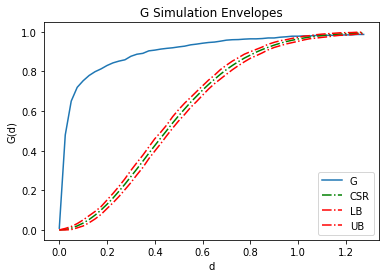

In [146]:
g_ms = Genv(pp_ms, intervals = 50, realizations = realizations_ms, dmax=1.25)
g_mass = g_ms.plot()

In [169]:
g_cali

In [326]:
g_cali = G(pp_cali, intervals = 50, dmax=1.5)
g_NE = G(pp_NE, intervals = 50, dmax=1.5)
g_MA = G(pp_MA, intervals = 50, dmax=1.5)

In [199]:
genv_cali = Genv(pp_cali, intervals = 50, realizations = realizations_cali, dmax=1)
genv_NE = Genv(pp_NE, intervals = 50, realizations = realizations_NE, dmax=0.8)
genv_MA = Genv(pp_NE, intervals = 50, realizations = realizations_MA, dmax=0.8)

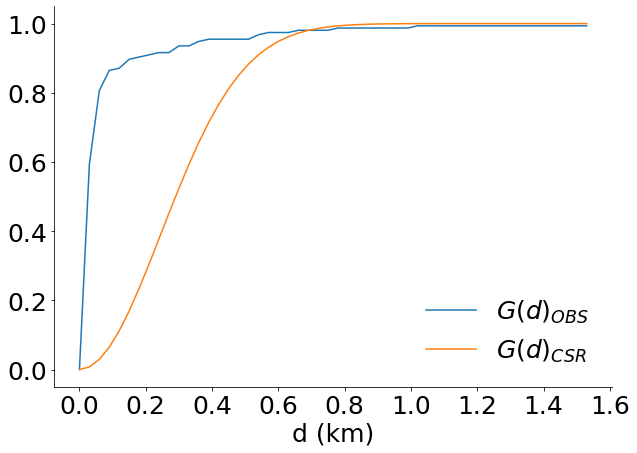

In [348]:
fig_cali_g, ax = plt.subplots(1, figsize=(10, 7))
g_cali.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('d (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$G(d)_{OBS}$')
L.get_texts()[1].set_text('$G(d)_{CSR}$')

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig_cali_g.savefig("G_cali.pdf", bbox_inches='tight')

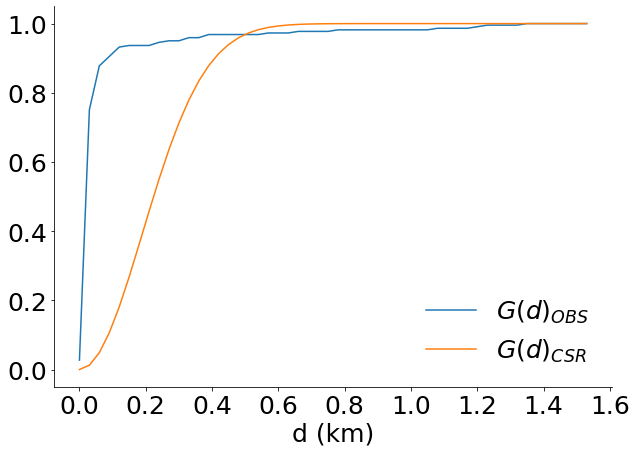

In [347]:
fig_NE_g, ax = plt.subplots(1, figsize=(10, 7))
g_NE.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('d (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$G(d)_{OBS}$')
L.get_texts()[1].set_text('$G(d)_{CSR}$')

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig_NE_g.savefig("G_NE.pdf", bbox_inches='tight')

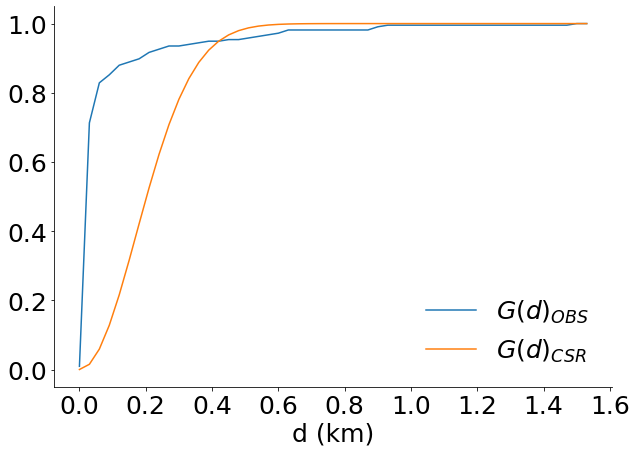

In [349]:
fig_MA_g, ax = plt.subplots(1, figsize=(10, 7))
g_MA.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('d (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$G(d)_{OBS}$')
L.get_texts()[1].set_text('$G(d)_{CSR}$')

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig_MA_g.savefig("G_MA.pdf", bbox_inches='tight')

## K-Function

In [292]:
kenv_cali = Kenv(pp_cali, realizations=realizations_cali)
kenv_NE = Kenv(pp_NE, dmax=7, realizations=realizations_NE)
kenv_MA = Kenv(pp_MA, dmax=7, realizations=realizations_MA)

In [322]:
k_cali = K(pp_cali, intervals=50, dmax=1.5)
k_NE = K(pp_NE, intervals=50, dmax=1.5)
k_MA = K(pp_MA, intervals=50, dmax=1.5)

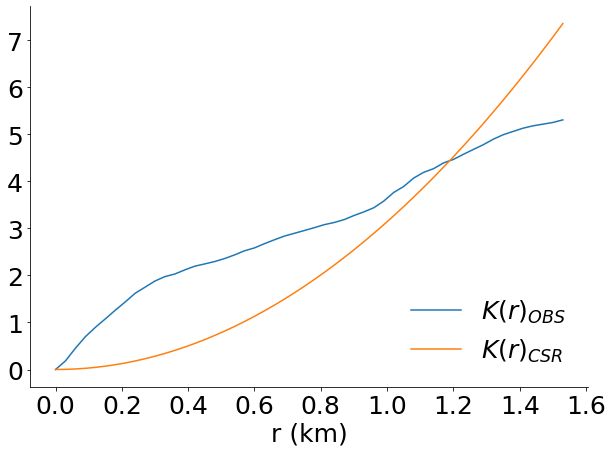

In [342]:
fig, ax = plt.subplots(1, figsize=(10, 7))
k_cali.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('r (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$K(r)_{OBS}$')
L.get_texts()[1].set_text('$K(r)_{CSR}$')


os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig.savefig("K_cali.pdf", bbox_inches='tight')

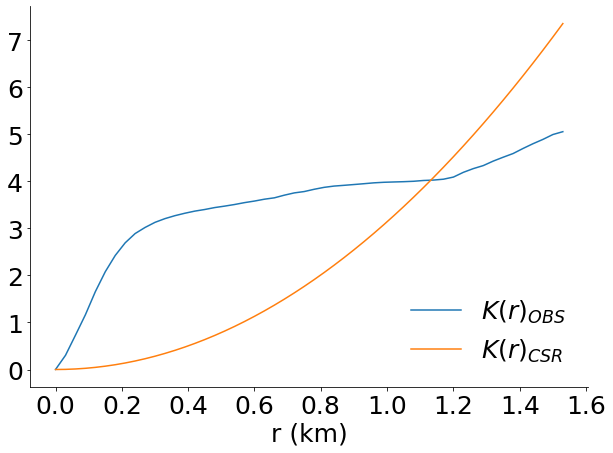

In [341]:
fig, ax = plt.subplots(1, figsize=(10, 7))
k_NE.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('r (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$K(r)_{OBS}$')
L.get_texts()[1].set_text('$K(r)_{CSR}$')


os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig.savefig("K_NE.pdf", bbox_inches='tight')

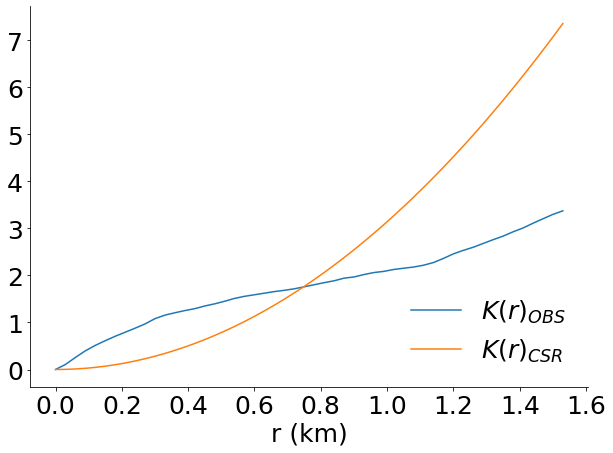

In [340]:
fig, ax = plt.subplots(1, figsize=(10, 7))
k_MA.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('r (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$K(r)_{OBS}$')
L.get_texts()[1].set_text('$K(r)_{CSR}$')


os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig.savefig("K_MA.pdf", bbox_inches='tight')

# AR-model

In [259]:
import datetime
from datetime import datetime, timedelta


cali_ar = ms_cali[['Date', 'Mass Shooting']]
MA_ar = ms_midatlantic[['Date', 'Mass Shooting']]
NE_ar = ms_northeast[['Date', 'Mass Shooting']]

cali_ar['date'] = pd.to_datetime(cali_ar.Date.str.strip(), format='%Y-%m-%d')
MA_ar['date'] = pd.to_datetime(MA_ar.Date.str.strip(), format='%Y-%m-%d')
NE_ar['date'] = pd.to_datetime(NE_ar.Date.str.strip(), format='%Y-%m-%d')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [260]:
# Date list for california
dt_cali = [cali_ar['date'].max() - timedelta(days=x) for x in range((cali_ar['date'].max()-cali_ar['date'].min()).days+1)]
dt_cali = pd.DataFrame(dt_cali)
dt_cali.columns=['date']

# Date list for NE
dt_NE = [NE_ar['date'].max() - timedelta(days=x) for x in range((NE_ar['date'].max()-NE_ar['date'].min()).days+1)]
dt_NE = pd.DataFrame(dt_NE)
dt_NE.columns=['date']

# Date list for MA
dt_MA = [MA_ar['date'].max() - timedelta(days=x) for x in range((MA_ar['date'].max()-MA_ar['date'].min()).days+1)]
dt_MA = pd.DataFrame(dt_MA)
dt_MA.columns=['date']

In [261]:
dt_cali['firstday'] = dt_cali['date'].apply(lambda x: x - timedelta(days=x.dayofweek))
dt_NE['firstday'] = dt_NE['date'].apply(lambda x: x - timedelta(days=x.dayofweek))
dt_MA['firstday'] = dt_MA['date'].apply(lambda x: x - timedelta(days=x.dayofweek))

In [262]:
cali_ar = pd.merge(cali_ar, dt_cali, on = 'date', how = 'right')
NE_ar = pd.merge(NE_ar, dt_NE, on = 'date', how = 'right')
MA_ar = pd.merge(MA_ar, dt_MA, on = 'date', how = 'right')

In [263]:
cali_week = cali_ar.groupby('firstday').count()
NE_week = NE_ar.groupby('firstday').count()
MA_week = MA_ar.groupby('firstday').count()

In [264]:
cali_week = cali_week.drop(columns = ['Date','date'])
NE_week = NE_week.drop(columns = ['Date','date'])
MA_week = MA_week.drop(columns = ['Date','date'])

## AR Model 2 

In [225]:
from pandas.plotting import autocorrelation_plot

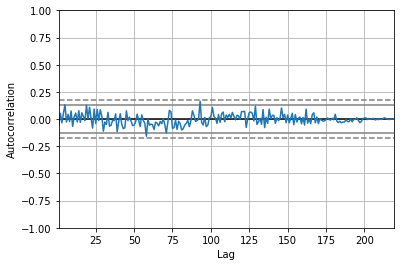

In [277]:
autocorrelation_plot(cali_week)

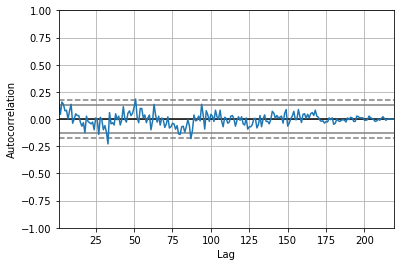

In [269]:
autocorrelation_plot(NE_week)

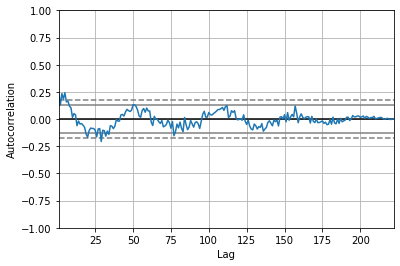

In [270]:
autocorrelation_plot(MA_week)

In [284]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(cali_week, order=(2,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:          Mass Shooting   No. Observations:                  219
Model:                     ARMA(2, 0)   Log Likelihood                -287.007
Method:                       css-mle   S.D. of innovations              0.897
Date:                Thu, 09 Jan 2020   AIC                            582.015
Time:                        11:58:00   BIC                            595.571
Sample:                    01-13-2014   HQIC                           587.490
                         - 03-19-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.7077      0.060     11.701      0.000       0.589       0.826
ar.L1.Mass Shooting    -0.0523      0.067     -0.776      0.439      -0.184       0.080
ar.L2.Mass Shoot

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


In [283]:
model = ARIMA(NE_week, order=(2,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:          Mass Shooting   No. Observations:                  219
Model:                     ARMA(2, 0)   Log Likelihood                -288.889
Method:                       css-mle   S.D. of innovations              0.905
Date:                Thu, 09 Jan 2020   AIC                            585.779
Time:                        11:57:20   BIC                            599.335
Sample:                    01-06-2014   HQIC                           591.254
                         - 03-12-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0093      0.074     13.662      0.000       0.865       1.154
ar.L1.Mass Shooting     0.1537      0.067      2.280      0.024       0.022       0.286
ar.L2.Mass Shoot

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


In [281]:
model = ARIMA(MA_week, order=(3,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:          Mass Shooting   No. Observations:                  222
Model:                     ARMA(3, 0)   Log Likelihood                -321.008
Method:                       css-mle   S.D. of innovations              1.027
Date:                Thu, 09 Jan 2020   AIC                            652.016
Time:                        11:56:57   BIC                            669.030
Sample:                    12-30-2013   HQIC                           658.885
                         - 03-26-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.9699      0.121      8.010      0.000       0.733       1.207
ar.L1.Mass Shooting     0.1980      0.066      3.008      0.003       0.069       0.327
ar.L2.Mass Shoot

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
